<a href="https://colab.research.google.com/github/Rowaida99/FisherFaces/blob/main/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing libraries**

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import argparse
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import pickle
import numpy as np
from os import listdir
from os.path import isfile, join
import os
from PIL import Image
from google.colab import files

## **Downloading and extracting the data from Google Drive**

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"1gWSJCngrtbQGSyqXnJUICjhCqNKyPwcd"})
downloaded.GetContentFile('archive.zip')        
!unzip -qq /content/archive.zip -d /content/dataset

replace /content/dataset/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## **Generating the data matrix and label vector**

In [ ]:
rootdir = '/content/dataset'
!mkdir '/content/output'
D = np.empty((0,10304), int)
Y = np.empty((0,1), int)
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith(".pgm"):
          filepath = subdir + os.sep + file
          temp =cv2.imread(filepath, 0) 
          img = cv2.imread(filepath, 0).flatten()
          label = subdir[-2:]
          if label[0] == 's':
            label = label[1]
          D = np.vstack((D, img))
          Y = np.vstack((Y, int(label)))

mkdir: cannot create directory ‘/content/output’: File exists


##**Defining constants**

In [ ]:
ALPHA = [0.8,0.85,0.9,0.95]
K = [1,3,5,7]
NON_FACES = [50,200,500,1000,5000]

## **Splitting the data**

In [ ]:
D_train = D[::2, :]
Y_train = Y[::2, :]
D_test = D[1::2, :]
Y_test = Y[1::2, :]

df = pd.DataFrame(D_train)
train_labels = pd.DataFrame(Y_train)
df_test = df = pd.DataFrame(D_test)
test_labels = pd.DataFrame(Y_test)

##**Mean Face**

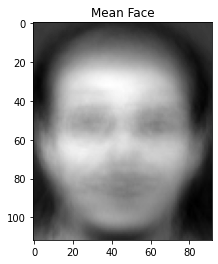

In [ ]:
my_path = '/content/output/'
my_file = 'Mean Face'
plt.imshow(np.reshape(df.mean().to_numpy(), (112, 92)), cmap=plt.get_cmap('gray'))
plt.savefig(os.path.join(my_path, my_file), bbox_inches = 'tight')
plt.title('Mean Face')
plt.show()
plt.close()

##**Classification Using PCA**

Function that returns the covariance matrix of given data matrix

In [ ]:
def get_covariance_matrix(data):
  my_df = pd.DataFrame(data)
  Z = my_df - my_df.mean().to_numpy()
  Zt = Z.transpose().to_numpy()
  n = my_df.count()
  my_cov = Zt @ Z
  my_cov = my_cov / n
  return my_cov

Function that returns the eigen values and eigen vectors of a given covariance matrix

In [ ]:
def get_eigens(cov):
  %%time
  eigenValues, eigenVectors = np.linalg.eigh(cov)
  idx = eigenValues.argsort()[::-1]   
  eigenValues = eigenValues[idx]
  eigenVectors = eigenVectors[:,idx]
  return eigenValues, eigenVectors

Function that returns the projection matrix from the eigen values and eigen vectors given the target alpha

In [ ]:
def get_variance_explained(e_values):
  total_egnvalues = sum(e_values)
  var_exp = [(i/total_egnvalues) for i in sorted(e_values, reverse=True)]
  return var_exp

In [ ]:
def get_projection_matrix(e_values, e_vectors, alpha):
  variance_explained = get_variance_explained(e_values)
  acc = 0
  i = 0
  projection_matrix = []
  while (acc < alpha):
    projection_matrix.append(e_vectors[:,i])
    acc += variance_explained[i]
    i += 1
  return np.array(projection_matrix).T

Applying PCA using First Nearest Neighbour Classifier at alpha = 0.9

In [ ]:
def PCA_constant_parameters(D_train,D_test,Y_train,Y_test,get_results=0):
  ! mkdir /content/output/PCA
  my_path = '/content/output/PCA/'
  training_scores = []
  test_scores = []
  my_file = 'PCA Accuracy with K=1.jpg'
  cov = get_covariance_matrix(D_train)
  eigenValues, eigenVectors = get_eigens(cov)
  alpha = 0.9
  p = get_projection_matrix(eigenValues, eigenVectors, alpha)
  reduced_train_data = D_train.dot(p)
  reduced_test_data = D_test.dot(p)
  classifier = KNeighborsClassifier(n_neighbors = 1, weights = 'distance')
  classifier.fit(reduced_train_data, Y_train)
  if get_results:
    predicted_labels = classifier.predict(reduced_test_data)
    compare = np.where(predicted_labels != Y_test)
    compare = np.array(compare)
  training_acc = classifier.score(reduced_train_data, Y_train)
  test_acc = classifier.score(reduced_test_data, Y_test)
  if get_results:
    return compare
  return test_acc

Function that compares the performance of PCA as the alpha and K in KNN Classifier change

In [ ]:
def PCA_different_splits(D_split_train, D_split_test,Y_split_train,Y_split_test,n_of_classes):
  ! mkdir /content/output/PCA
  my_path = '/content/output/PCA/'
  r, c = D_split_train.shape
  r2, c2 = D_split_test.shape
  tot = r + r2
  train_length = r*100/tot
  test_length = r2*100/tot
  my_file = 'PCA Accuracy with varying K at ratio of ' + str(train_length) + '-' + str(test_length) + '.jpg'
  plt.figure(figsize=(14,6))
  new_cov = get_covariance_matrix(D_split_train)
  eigen_values, eigen_vectors = get_eigens(new_cov)
  for k in K:
    training_scores = []
    test_scores = []
    for alpha in ALPHA:
      p = get_projection_matrix(eigen_values, eigen_vectors, alpha)
      reduced_train_data = D_split_train.dot(p)
      reduced_test_data = D_split_test.dot(p)
      classifier = KNeighborsClassifier(n_neighbors = k, weights = 'distance')
      classifier.fit(reduced_train_data, Y_split_train)
      training_acc = classifier.score(reduced_train_data, Y_split_train)
      test_acc = classifier.score(reduced_test_data, Y_split_test)
      training_scores.append(training_acc)
      test_scores.append(test_acc)
    if k == 1:
      pca_comparator = test_scores
    plt.plot(ALPHA, test_scores, label = 'Test Data, K = {}'.format(k))
    plt.scatter(ALPHA, test_scores, color = 'r')
    for i_x, i_y in zip(ALPHA, test_scores):
        plt.text(i_x, i_y, '({}, {:.3f})'.format(i_x, i_y), fontsize = 12)
  plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',ncol=2, mode="expand", borderaxespad=0.)
  plt.xlabel('Reliability factor')
  plt.ylabel('Accuracy')
  plt.title('PCA Accuracy with different k and with splits ' + str(train_length) + '-' + str(test_length))
  plt.savefig(os.path.join(my_path, my_file), bbox_inches = 'tight')
  plt.show()
  plt.close()
  return pca_comparator

Utility function that splits the data based on the number of desired train instances per person

In [ ]:
def split(train_count_per_person):
  ind = random.sample(range(0, 10), train_count_per_person)
  ind.sort()
  D_train_splitted = []
  Y_train_splitted = []
  D_test_splitted = []
  Y_test_splitted = []
  for i in range(0, len(D), 10):
    for j in range(0,10):
      if j in ind:
        D_train_splitted.append(D[i+j,:])
        Y_train_splitted.append(Y[i+j])
      if j not in ind:
        D_test_splitted.append(D[i+j,:])
        Y_test_splitted.append(Y[i+j])
  D_train_splitted=np.array(D_train_splitted)
  Y_train_splitted=np.array(Y_train_splitted)
  D_test_splitted=np.array(D_test_splitted)
  Y_test_splitted=np.array(Y_test_splitted)
  return D_train_splitted, Y_train_splitted, D_test_splitted, Y_test_splitted

BONUS: Comparing the 50-50 split to 70-30 split among varying ALPHA's and K's in PCA

mkdir: cannot create directory ‘/content/output/PCA’: File exists
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed

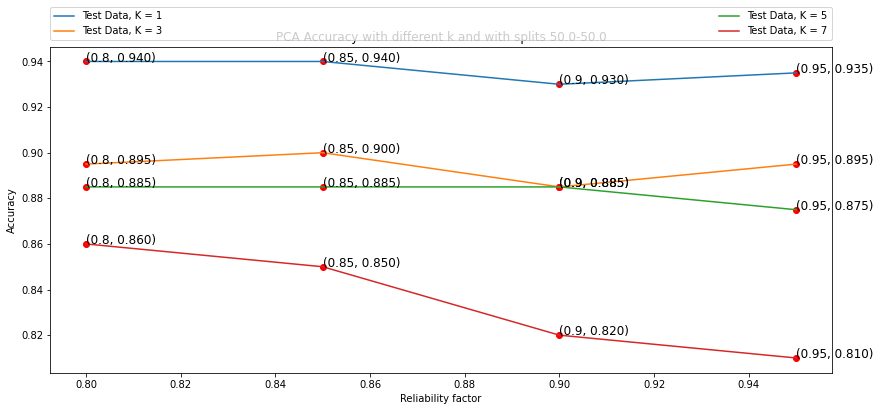

mkdir: cannot create directory ‘/content/output/PCA’: File exists
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed

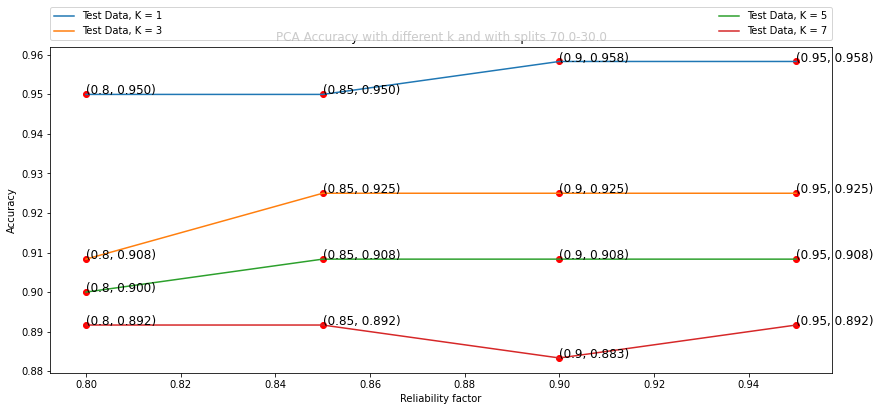

In [ ]:
#Split the data 5-5
pca_results_50 = PCA_different_splits(D_train, D_test,Y_train,Y_test,40)

#Split the data 7-3
D_split_train, Y_split_train, D_split_test, Y_split_test = split(7)
pca_results_70 = PCA_different_splits(D_split_train, D_split_test,Y_split_train,Y_split_test,40)

##**Classification Using LDA**

Main function for LDA

In [ ]:
def LDA_Calculation(D_train,D_test,Y_train,Y_test,No_ofClasses):
    Data = D_train
    Label = Y_train
    size,v=Data.shape
    num_samples=int(size/No_ofClasses)
    Mean=np.zeros((No_ofClasses, v))
    for x in range(0,No_ofClasses):
      Mean[x,:] = np.mean(Data[(Label==(x+1)).flatten()], axis=0, keepdims=True)
    overallMean=np.array([np.mean(Data,axis=0,keepdims=True)])
    B = B_Calculation(Mean,overallMean,num_samples,v)
    S=S_Calculation(Data,Label,Mean,num_samples,size,v,No_ofClasses)
    eigenvalues,eigenvectors=eigV(S,B)
    return eigenvalues, eigenvectors

LDA classifier tuning

In [ ]:
def LDA_Classification(projection,Data,D_test,Y_train,Y_test):
  Ptrain,Ptest=Proj_data(projection,Data,D_test)
  train_scores = []
  test_scores = []
  for k in K:
    train_acc, test_acc = KNearestNeighbours(Ptrain, Ptest, Y_train, Y_test, k)
    train_scores.append(train_acc)
    test_scores.append(test_acc)
  return test_scores,train_scores

Calculation of the B matrix

In [ ]:
def B_Calculation(Mean,overallMean,num_samples,v):
    B=np.zeros((v,v))
    M1=(Mean - overallMean)
    M2=(Mean - overallMean).T
    M1=np.squeeze(M1)
    M2=np.squeeze(M2)
    B=num_samples*M2.dot(M1)
    return B

Calculation of the S matrix

In [ ]:
def S_Calculation(Data,Label,Mean,num_samples,size,v,No_ofClasses):
    S=np.zeros((v,v))
    for i in range (0,No_ofClasses):
      Z=Data[(Label==(i+1)).flatten()]-Mean[i]
      Ztrans=Z.T
      S+=Ztrans.dot(Z)
    return S

A function to calculate eigenvalues and vectors of LDA

In [ ]:
def eigV(S,B):
    SInv=np.linalg.pinv(S,hermitian=True)
    eigenvalues,eigenvectors=np.linalg.eigh(np.dot(SInv,B))
    w2Abs=np.absolute(eigenvalues)
    idx=w2Abs.argsort()[::-1]
    w2Abs=w2Abs[idx]
    eigenvectors=eigenvectors[:,idx]
    eigenvectors=np.real(eigenvectors)
    return eigenvalues,eigenvectors

Utility function to project given data using a given projection matrix

In [ ]:
def Proj_data(projection,D_train,D_test):
    Ptrain=np.dot(D_train,projection)
    Ptest=np.dot(D_test,projection)
    return Ptrain,Ptest

A function that returns the accuracy of given data using K-NN of a given k value

In [ ]:
def KNearestNeighbours(reduced_train_data, reduced_test_data, Y_tran, Y_test, k):
    training_scores = []
    test_scores = []
    classifier = KNeighborsClassifier(n_neighbors = k, weights = 'distance')
    classifier.fit(reduced_train_data, sorted(Y_train))
    training_acc = classifier.score(reduced_train_data, sorted(Y_train))
    test_acc = classifier.score(reduced_test_data, sorted(Y_test))
    training_scores.append(training_acc)
    test_scores.append(test_acc)
    return training_acc,test_acc

Calling the LDA classification functions on Face Data

In [ ]:
eigenvalues, eigenvectors = LDA_Calculation(D_train,D_test,Y_train,Y_test,40)
projection = eigenvectors[:,:39]
test_scores,train_scores = LDA_Classification(projection,D_train,D_test,Y_train,Y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


Plotting LDA accuracy against K and against PCA results

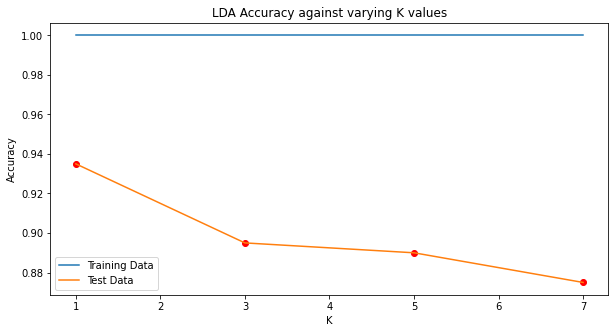

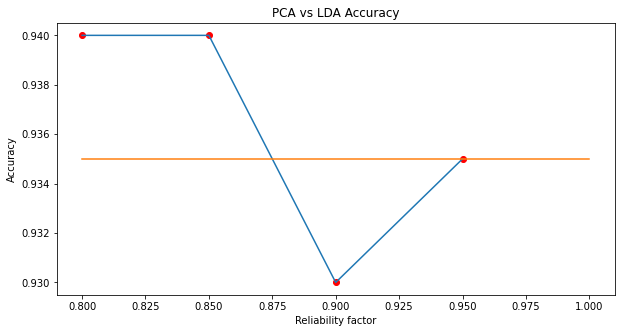

In [ ]:
! mkdir /content/output/LDA
my_path = '/content/output/LDA/'
my_file = 'LDA Accuracy with varying K.jpg'
plt.figure(figsize=(10,5))
plt.plot(K,train_scores, label = 'Training Data')
plt.plot(K,test_scores, label = 'Test Data')
plt.legend()
plt.scatter(K,test_scores, color = 'r')
plt.legend()
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('LDA Accuracy against varying K values')
plt.savefig(os.path.join(my_path, my_file), bbox_inches = 'tight')
plt.show()
plt.close()

my_file = 'LDA vs PCA Accuracy.jpg'
plt.figure(figsize=(10,5))
plt.scatter(ALPHA, pca_results_50, color='r',label = 'PCA Results')
plt.plot(ALPHA, pca_results_50, label = 'PCA Results')
plt.plot(np.linspace(0.8,1,500), np.repeat(test_scores[0], 500), label = 'LDA Results')
plt.xlabel('Reliability factor')
plt.ylabel('Accuracy')
plt.title('PCA vs LDA Accuracy')
plt.savefig(os.path.join(my_path, my_file), bbox_inches = 'tight')
plt.show()
plt.close()

##**Loading CIFAR-10 Dataset**

In [ ]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar  -xvf /content/cifar-10-python.tar.gz

--2021-05-19 00:35:18--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  49.3MB/s    in 3.6s    

2021-05-19 00:35:21 (45.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


Unzipping the dataset

In [ ]:
# Function to unpickle the dataset
def unpickle_all_data(directory):
    
    # Initialize the variables
    train = dict()
    test = dict()
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    # Iterate through all files that we want, train and test
    # Train is separated into batches
    for filename in listdir(directory):
        if isfile(join(directory, filename)):
            # The train data
            if 'data_batch' in filename:
                print('Handing file: %s' % filename)
                # Opent the file
                with open(directory + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo, encoding='bytes')
                if 'data' not in train:
                    train['data'] = data[b'data']
                    train['labels'] = np.array(data[b'labels'])
                else:
                    train['data'] = np.concatenate((train['data'], data[b'data']))
                    train['labels'] = np.concatenate((train['labels'], data[b'labels']))
            # The test data
            elif 'test_batch' in filename:
                print('Handing file: %s' % filename)
                # Open the file
                with open(directory + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo, encoding='bytes')
                test['data'] = data[b'data']
                test['labels'] = data[b'labels']
    # Manipulate the data to the propper format
    for image in train['data']:
        train_x.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    train_y = [label for label in train['labels']]
    for image in test['data']:
        test_x.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    test_y = [label for label in test['labels']]
    # Transform the data to np array format
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    test_x = np.array(test_x)
    test_y = np.array(test_y)
    return (train_x, train_y), (test_x, test_y)
# Run the function with and include the folder where the data are
(x_train, y_train), (x_test, y_test) = unpickle_all_data(os.getcwd() + '/cifar-10-batches-py/')

Handing file: test_batch
Handing file: data_batch_2
Handing file: data_batch_1
Handing file: data_batch_4
Handing file: data_batch_3
Handing file: data_batch_5


##**Generating the new dataset (Faces vs Non-Faces)**

Utility function that converts a given RGB image to a grayscale image

In [ ]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray = cv2.resize(gray,(112,92)).flatten()
    return gray

In [ ]:
def get_dataset_with_nonfaces(num_of_nonfaces):
  # number of faces = 200 in training data and 200 in test data
  # number of non_faces depends on the argument of the function
  
  # # Non faces part in the training data
  rd = random.sample(range(50000), num_of_nonfaces)
  non_face_train = np.empty((200 + num_of_nonfaces,10304))
  non_face_train_label = np.ones(200 + num_of_nonfaces)*2

  for i in range(len(rd)):
    curr_img = rgb2gray(x_train[rd[i]])
    non_face_train[i] = curr_img

  # # Non faces part in the test data (1000)
  rd = random.sample(range(10000), 1000)
  non_face_test = np.empty((1200,10304))
  non_face_test_label = np.ones(1200)*2
  for i in range(len(rd)):
    curr_img = rgb2gray(x_test[rd[i]])
    non_face_test[i] = curr_img

  # # Appending the faces data on the non-faces data to form the new training and test data
  non_face_train[num_of_nonfaces:,:] = D_train[:200,:]
  non_face_test[1000:,:] = D_test[:200,:]
  non_face_train_label[num_of_nonfaces:] = np.ones(200)
  non_face_test_label[1000:] = np.ones(200)
  c = list(zip(non_face_train, non_face_train_label))
  random.shuffle(c)
  non_face_train, non_face_train_label = zip(*c)
  non_face_train = np.array(non_face_train)
  non_face_train_label = np.array(non_face_train_label)

  return non_face_train, non_face_test, non_face_train_label, non_face_test_label
  

##**Testing the model on non-faces dataset**

Calling the LDA classification functions on non-face data with 39 dominant eigenvectors

In [ ]:
# non_face_train, non_face_test, non_face_train_label, non_face_test_label = get_dataset_with_nonfaces(1000)
# eigenvalues, eigenvectors = LDA_Calculation(non_face_train,non_face_test,non_face_train_label,non_face_test_label,2)
# projection = eigenvectors[:,:39]
# print(non_face_train.shape,non_face_test.shape,non_face_train_label.shape,non_face_test_label.shape)
# test_scoresAll,train_scoresAll = LDA_Classification(projection, non_face_train, non_face_test, 
#                                                     non_face_train_label, non_face_test_label)

Calling the PCA classification functions on non-face data

mkdir: cannot create directory ‘/content/output/PCA’: File exists
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs
mkdir: cannot create directory ‘/content/output/PCA’: File exists
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.5 µs
mkdir: cannot create directory ‘/content/output/PCA’: File exists
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
mkdir: cannot create directory ‘/content/output/PCA’: File exists
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 10.3 µs
mkdir: cannot create directory ‘/content/output/PCA’: File exists
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

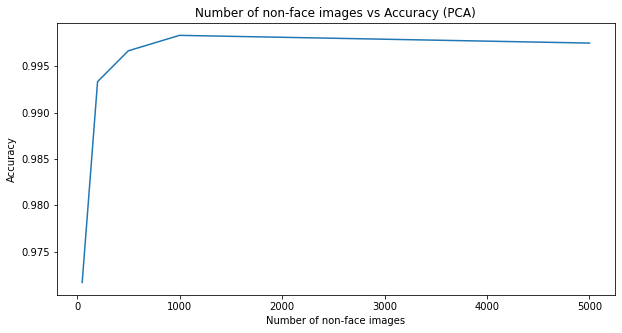

In [ ]:
non_faces_pca_scores = []
! mkdir /content/output/Non-faces
my_path = '/content/output/Non-faces'
my_file = 'Changing number of non-faces.jpg'
for n in NON_FACES:
  non_face_train2, non_face_test2, non_face_train_label2, non_face_test_label2 = get_dataset_with_nonfaces(n)
  curr_score = PCA_constant_parameters(non_face_train2,non_face_test2,non_face_train_label2,non_face_test_label2)
  non_faces_pca_scores.append(curr_score)
  plt.figure(figsize=(10,5))
plt.plot(NON_FACES,non_faces_pca_scores)
plt.xlabel('Number of non-face images')
plt.ylabel('Accuracy')
plt.title('Number of non-face images vs Accuracy (PCA)')
plt.savefig(os.path.join(my_path, my_file), bbox_inches = 'tight')
plt.show()
plt.close()

##**Showing success and failure misclassification cases**

Calling PCA classifier to show the success and failure classifications

In [ ]:
non_face_train2, non_face_test2, non_face_train_label2, non_face_test_label2 = get_dataset_with_nonfaces(200)
compare = PCA_constant_parameters(non_face_train2, non_face_test2, non_face_train_label2, non_face_test_label2,1)

mkdir: cannot create directory ‘/content/output/PCA’: File exists
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


Output of classified and misclassified pictures

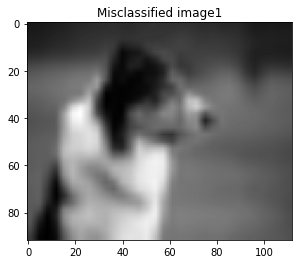

classified as  2.0


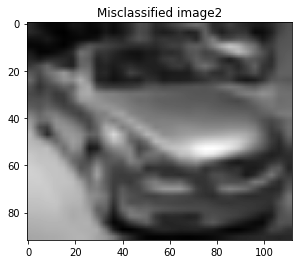

classified as  2.0


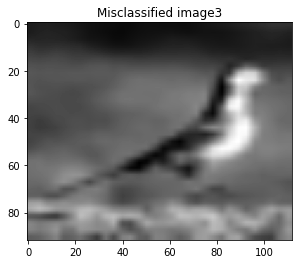

classified as  2.0


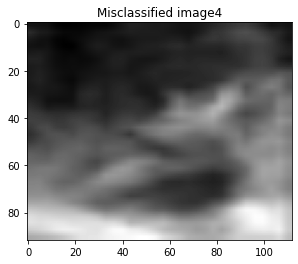

classified as  2.0


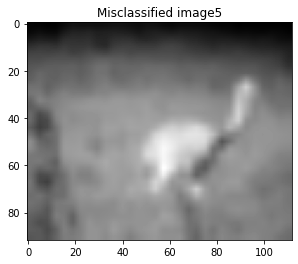

classified as  2.0


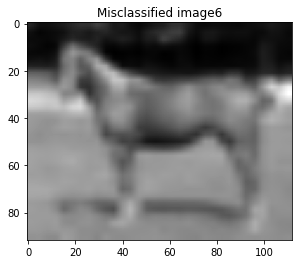

classified as  2.0


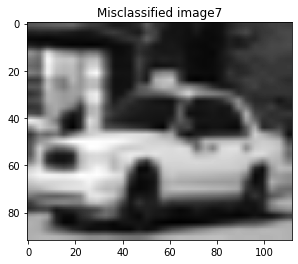

classified as  2.0


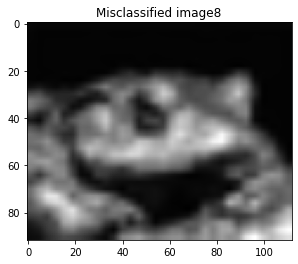

classified as  2.0


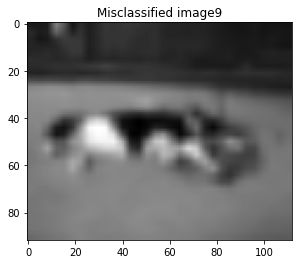

classified as  2.0


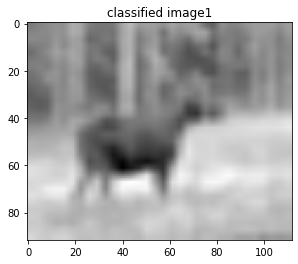

classified as  2.0


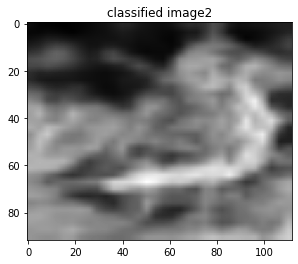

classified as  2.0


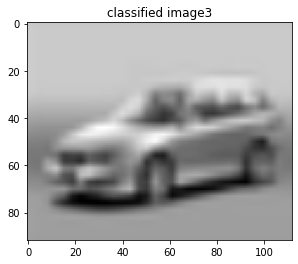

classified as  2.0


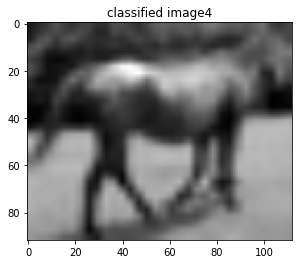

classified as  2.0


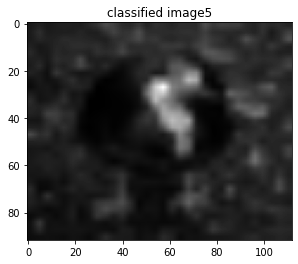

classified as  2.0


In [ ]:
!mkdir /content/output/Classifications
my_path = '/content/output/Classifications'
compare = np.array(compare)
compare = np.squeeze(compare)
for i in range(len(compare)):
  my_img = non_face_test2[compare[i]]
  my_file = 'misclassified img ' + str(i + 1)
  plt.imshow(np.reshape(my_img, (92, 112)), cmap=plt.get_cmap('gray'))
  plt.savefig(os.path.join(my_path, my_file), bbox_inches = 'tight')
  plt.title('Misclassified image' + str(i + 1))
  plt.show()
  print("classified as ",non_face_test_label2[compare[i]])
  plt.close()
# label 2 for nonfaces and 1 for faces
for i in range(5):
  if i not in compare:
    my_img = non_face_test2[i]
    my_file = 'classified img ' + str(i + 1)
    plt.imshow(np.reshape(my_img, (92, 112)), cmap=plt.get_cmap('gray'))
    plt.savefig(os.path.join(my_path, my_file), bbox_inches = 'tight')
    plt.title('classified image' + str(i + 1))
    plt.show()
    print("classified as ",non_face_test_label2[i])
    plt.close()

##**Zipping and downloading output figures**

In [ ]:
!zip -qq -r /content/output.zip /content/output
files.download("/content/output.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>